
# Inputs ? outputs ? simulated image (pretrained RF, comp-aware)
Uses a saved `foam_rfr.pkl` (lamella excluded) to predict outputs from accessible inputs, evaluates metrics, maps predictions to real frames using composition + frame_index alignment, and provides a time-sweep animation saved to GIF.


In [35]:

from pathlib import Path

def find_data_dir() -> Path:
    search_bases = [
        Path.cwd(),
        Path.cwd().parent,
        Path.cwd().parent.parent,
        Path.cwd().parent.parent.parent,
        Path(r'C:/Users/aisci/OneDrive/Desktop/Foam bubble data/AisciaMicroscopeHackathon/DTMicroscope'),
        Path(r'C:/Users/aisci/OneDrive/Desktop/Foam bubble data/AisciaMicroscopeHackathon/DTMicroscope-main'),
        Path(r'C:/Users/aisci/OneDrive/Desktop/Foam bubble data/DTMicroscope-main'),
    ]
    for base in search_bases:
        candidate = (Path(base).resolve() / 'data' / 'foam')
        if candidate.exists() and any(candidate.glob('*.h5')):
            return candidate
    for base in search_bases:
        candidate = (Path(base).resolve() / 'data' / 'foam')
        if candidate.exists():
            return candidate
    raise FileNotFoundError('Could not find data/foam. Set DATA_DIR manually below.')

DATA_DIR = find_data_dir()
h5_files = sorted(DATA_DIR.glob('*.h5'))
if not h5_files:
    raise FileNotFoundError(f'No .h5 files in {DATA_DIR}.')

# Use the merged table that includes nanoparticle wt.%
CSV_PATH = Path('foam_training_table_with_nano.csv')
MODEL_PATH = Path('foam_rfr.pkl')

print('Using data folder:', DATA_DIR)
print('Found', len(h5_files), 'NSID files')
print('CSV:', CSV_PATH.resolve())
print('Model:', MODEL_PATH.resolve())


Using data folder: C:\Users\aisci\OneDrive\Desktop\Foam bubble data\DTMicroscope-main\data\foam
Found 10 NSID files
CSV: C:\Users\aisci\OneDrive\Desktop\Foam bubble data\AisciaMicroscopeHackathon\DTMicroscope\notebooks\foam\foam_training_table_with_nano.csv
Model: C:\Users\aisci\OneDrive\Desktop\Foam bubble data\AisciaMicroscopeHackathon\DTMicroscope\notebooks\foam\foam_rfr.pkl


In [36]:

import os, io, re
import numpy as np
import pandas as pd
import h5py
from PIL import Image
from collections import defaultdict
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from skimage.metrics import structural_similarity
import joblib

os.environ['HDF5_USE_FILE_LOCKING'] = 'FALSE'
# Higher target size + better resampling for clearer frames
TARGET_SIZE = 192

def downsample_frame(frame: np.ndarray) -> np.ndarray:
    img = Image.fromarray(frame.astype(np.uint8))
    img = img.resize((TARGET_SIZE, TARGET_SIZE), resample=Image.Resampling.LANCZOS)
    return np.array(img, dtype=np.float32) / 255.0

def normalize_surf(text: str) -> str:
    return re.sub(r'\s+', ' ', text.replace('_', ' ')).strip().lower()

def comp_key_from_h5(f: h5py.File):
    comp_group = f.get('Measurement_000/metadata/composition')
    if comp_group is None:
        return None
    items = []
    for child in comp_group.keys():
        g = comp_group[child]
        wt = float(g.attrs.get('concentration_wt_percent', 0.0))
        surf = normalize_surf(str(g.attrs.get('surfactant', '')))
        items.append((surf, round(wt, 4)))
    items.sort()
    return tuple(items)

def comp_key_from_row(row):
    keys = []
    for col, val in row.items():
        if col.startswith('surfactant_') and col.endswith('_wt_pct'):
            v = float(val)
            if abs(v) > 1e-9:
                surf = normalize_surf(col.replace('surfactant_', '').replace('_wt_pct', ''))
                keys.append((surf, round(v, 4)))
    keys.sort()
    return tuple(keys) if keys else None

def load_frames_by_comp(h5_list):
    comp_to_frames = {}
    fallback_frames = []
    for h5 in h5_list:
        with h5py.File(h5, 'r') as f:
            frames = f['Measurement_000/Channel_000/generic/generic'][()]
            comp_key = comp_key_from_h5(f)
        small = np.stack([downsample_frame(fr) for fr in frames])
        if comp_key:
            comp_to_frames[comp_key] = small
        else:
            fallback_frames.append(small)
    fallback_frames = np.concatenate(fallback_frames, axis=0) if fallback_frames else np.empty((0, TARGET_SIZE, TARGET_SIZE))
    return comp_to_frames, fallback_frames

comp_to_frames, fallback_frames = load_frames_by_comp(h5_files)
print('Loaded frames by composition keys:', len(comp_to_frames), '; fallback frames:', fallback_frames.shape)


Loaded frames by composition keys: 10 ; fallback frames: (0, 192, 192)


In [37]:

# Load model and table
bundle = joblib.load(MODEL_PATH)
model = bundle['model']
input_cols = bundle['input_cols']
target_cols = bundle['target_cols']

df = pd.read_csv(CSV_PATH)
missing_inputs = [c for c in input_cols if c not in df.columns]
missing_targets = [c for c in target_cols if c not in df.columns]
if missing_inputs or missing_targets:
    raise ValueError(f"Missing columns -> inputs: {missing_inputs}, targets: {missing_targets}")

# Align frames to rows using composition + frame_index; keep only rows whose composition exists in H5
frames_aligned = []
comp_keys_aligned = []
times_aligned = []
skipped_rows = 0
for _, row in df.iterrows():
    key = comp_key_from_row(row)
    frame_idx = int(row['frame_index']) if 'frame_index' in row else None
    t_val = float(row['time_s']) if 'time_s' in row else 0.0
    if key in comp_to_frames:
        frames_arr = comp_to_frames[key]
        idx = frame_idx if frame_idx is not None else 0
        idx = max(0, min(len(frames_arr)-1, idx))
        frames_aligned.append(frames_arr[idx])
        comp_keys_aligned.append(key)
        times_aligned.append(t_val)
    else:
        skipped_rows += 1
if skipped_rows:
    print('Skipped rows without composition match in H5:', skipped_rows)

all_frames = np.stack(frames_aligned)

X = df.iloc[:len(comp_keys_aligned)][input_cols].fillna(df[input_cols].median(numeric_only=True))
y = df.iloc[:len(comp_keys_aligned)][target_cols].fillna(df[target_cols].median(numeric_only=True))
times_arr = np.array(times_aligned)

if len(X) != len(all_frames):
    min_len = min(len(X), len(all_frames))
    print(f"Aligning to min length {min_len} due to mismatch")
    X = X.iloc[:min_len]
    y = y.iloc[:min_len]
    all_frames = all_frames[:min_len]
    comp_keys_aligned = comp_keys_aligned[:min_len]
    times_arr = times_arr[:min_len]

# Build per-comp structures (sorted by time) for time-based retrieval
comp_data = {}
for ck in set(comp_keys_aligned):
    idxs = [i for i, k in enumerate(comp_keys_aligned) if k == ck]
    times_ck = times_arr[idxs]
    frames_ck = all_frames[idxs]
    order = np.argsort(times_ck)
    comp_data[ck] = {
        'times': times_ck[order],
        'frames': frames_ck[order],
        'y': y.iloc[idxs].reset_index(drop=True).iloc[order].reset_index(drop=True)
    }

# Per-comp NN on outputs for general mapping
comp_nn = {}
for ck, data in comp_data.items():
    scaler = StandardScaler()
    scaled = scaler.fit_transform(data['y'])
    nn = NearestNeighbors(n_neighbors=1)
    nn.fit(scaled)
    comp_nn[ck] = {'scaler': scaler, 'nn': nn, 'frames': data['frames']}

# Global fallback uses aligned data only
scaler_global = StandardScaler()
scaled_global = scaler_global.fit_transform(y)
nn_global = NearestNeighbors(n_neighbors=1)
nn_global.fit(scaled_global)

preds = model.predict(X)
from sklearn.metrics import r2_score, mean_squared_error
rmse = np.sqrt(mean_squared_error(y, preds))
r2 = r2_score(y, preds, multioutput='uniform_average')
print(f"Overall RMSE: {rmse:.4f}, R2: {r2:.4f}")

# Map predictions to frames using composition-specific NN
sim_frames = []
for i, p in enumerate(preds):
    ck = comp_keys_aligned[i]
    if ck in comp_nn:
        scaler = comp_nn[ck]['scaler']
        nn = comp_nn[ck]['nn']
        frames_arr = comp_nn[ck]['frames']
    else:
        scaler = scaler_global
        nn = nn_global
        frames_arr = all_frames
    scaled_p = scaler.transform([p])
    _, idx_nn = nn.kneighbors(scaled_p)
    sim_frames.append(frames_arr[idx_nn[0][0]])

sim_frames = np.stack(sim_frames)
img_mse = np.mean((all_frames - sim_frames) ** 2, axis=(1,2))
img_ssim = [structural_similarity(all_frames[i], sim_frames[i], data_range=1.0) for i in range(len(all_frames))]
print(f"Image similarity -> MSE mean {np.mean(img_mse):.6f}, median {np.median(img_mse):.6f}")
print(f"Image similarity -> SSIM mean {np.mean(img_ssim):.4f}, median {np.median(img_ssim):.4f}")


Skipped rows without composition match in H5: 2324
Overall RMSE: 31341.5381, R2: 0.7545


c:\Users\aisci\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\aisci\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\aisci\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\aisci\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\aisci\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2691: U

Image similarity -> MSE mean 0.021406, median 0.022727
Image similarity -> SSIM mean 0.1650, median 0.1095


Predicted outputs:


,predicted
BC [mm??],1.553858
M?B?A? [?m?],701264.739903
SD M?B?A? [?m?],629211.246917
Ravg [?m],416.266132
Rrms [?m],468.806107
R21 [?m],527.909353
R32 [?m],603.429611
metric_v,1.028479
metric_w,1.538836
lamella_thickness_mm,0.020056


Actual outputs:


,actual
BC [mm??],1.557
M?B?A? [?m?],642415.000
SD M?B?A? [?m?],615274.000
Ravg [?m],398.000
Rrms [?m],452.000
R21 [?m],514.000
R32 [?m],595.000
metric_v,1.000
metric_w,2.000
lamella_thickness_mm,0.020


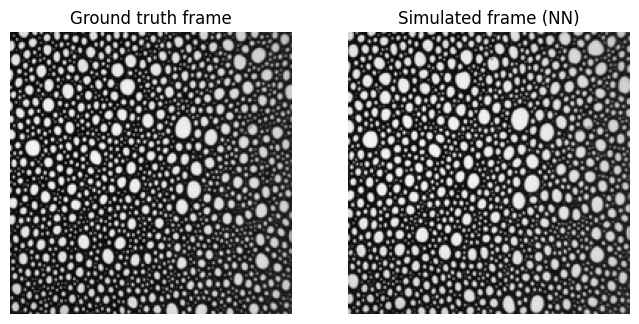

In [38]:

import matplotlib.pyplot as plt

sample_idx = 70
pred_series = pd.Series(preds[sample_idx], index=target_cols)
actual_series = y.iloc[sample_idx]
gt_frame = all_frames[sample_idx]
sim_frame = sim_frames[sample_idx]

print('Predicted outputs:')
display(pred_series.to_frame(name='predicted'))
print('Actual outputs:')
display(actual_series.to_frame(name='actual'))

fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].imshow(gt_frame, cmap='gray')
axes[0].set_title('Ground truth frame')
axes[0].axis('off')
axes[1].imshow(sim_frame, cmap='gray')
axes[1].set_title('Simulated frame (NN)')
axes[1].axis('off')
plt.show()


Input warnings:
 - surfactant_coco_b_wt_pct above max 0.25, clamping.
Predicted outputs for custom inputs:


c:\Users\aisci\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


,predicted
BC [mm??],7.191259e-01
M?B?A? [?m?],1.434407e+06
SD M?B?A? [?m?],1.096579e+06
Ravg [?m],6.135674e+02
Rrms [?m],6.733056e+02
R21 [?m],7.389362e+02
R32 [?m],8.188473e+02
metric_v,9.957557e-01
metric_w,7.912504e-01
lamella_thickness_mm,2.000000e-02


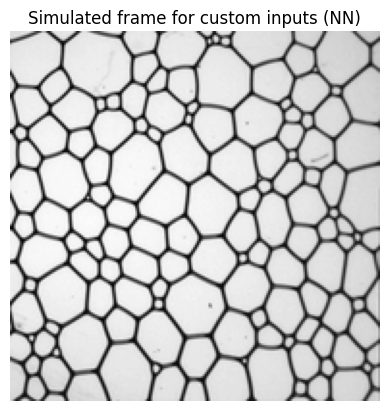

In [39]:

# Predict from custom inputs and retrieve nearest frame (with basic value checks)
import numpy as np

# Compute observed ranges from the table for quick validation
input_ranges = {}
for col in input_cols:
    if col in df.columns:
        input_ranges[col] = (df[col].min(), df[col].max())

# Simple validator: clamps to observed min/max and warns for unreasonable sums

def validate_inputs(row: dict):
    cleaned = {}
    warnings = []
    # Clamp per-column to observed min/max if available
    for col in input_cols:
        val = float(row.get(col, 0.0))
        if col in input_ranges:
            lo, hi = input_ranges[col]
            if val < lo:
                warnings.append(f"{col} below min {lo:.4g}, clamping.")
                val = lo
            if val > hi:
                warnings.append(f"{col} above max {hi:.4g}, clamping.")
                val = hi
        cleaned[col] = val
    # Surfactant logic: total should be between 0 and ~1.5; nanoparticle non-negative
    surf_cols = [c for c in input_cols if c.startswith('surfactant_')]
    surf_sum = sum(cleaned.get(c, 0.0) for c in surf_cols)
    if surf_sum < 0:
        warnings.append('Total surfactant < 0, setting all surfactants to 0.')
        for c in surf_cols:
            cleaned[c] = 0.0
    if surf_sum > 1.5:
        warnings.append(f'Total surfactant {surf_sum:.3f} seems high; consider rescaling.')
    # Nanoparticle logic
    if 'nanoparticle_al2o3_wt_pct' in cleaned:
        if cleaned['nanoparticle_al2o3_wt_pct'] < 0:
            warnings.append('Nanoparticle wt% < 0; setting to 0.')
            cleaned['nanoparticle_al2o3_wt_pct'] = 0.0
        if cleaned['nanoparticle_al2o3_wt_pct'] > 0.1:
            warnings.append('Nanoparticle wt% > 0.1; outside observed range (<=0.025).')
    return cleaned, warnings

custom_inputs = {
    'time_s': 1700.0,
    'surfactant_coco_b_wt_pct': 0.5,
    'surfactant_coco_betain_wt_pct': 0.5,
    'surfactant_capryl_glucoside_wt_pct': 0.0,
    'surfactant_coco_glucoside_wt_pct': 0.5,
    'nanoparticle_al2o3_wt_pct': 0.0,
    'temperature_c': 22.0,  # include only if present
}

row, warns = validate_inputs(custom_inputs)
if warns:
    print('Input warnings:')
    for w in warns:
        print(' -', w)

X_custom = pd.DataFrame([row])
custom_pred = model.predict(X_custom)[0]
ck_custom = comp_key_from_row(row)
if ck_custom in comp_nn:
    scaler = comp_nn[ck_custom]['scaler']
    nn = comp_nn[ck_custom]['nn']
    frames_arr = comp_nn[ck_custom]['frames']
else:
    scaler = scaler_global
    nn = nn_global
    frames_arr = all_frames
scaled_custom = scaler.transform([custom_pred])
_, nn_custom = nn.kneighbors(scaled_custom)
custom_frame = frames_arr[nn_custom[0][0]]

print('Predicted outputs for custom inputs:')
display(pd.Series(custom_pred, index=target_cols).to_frame(name='predicted'))

plt.imshow(custom_frame, cmap='gray')
plt.title('Simulated frame for custom inputs (NN)')
plt.axis('off')
plt.show()


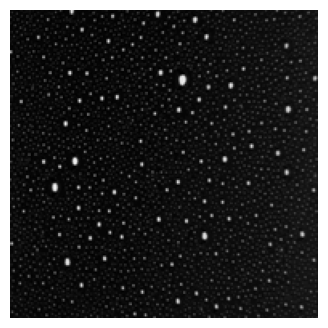

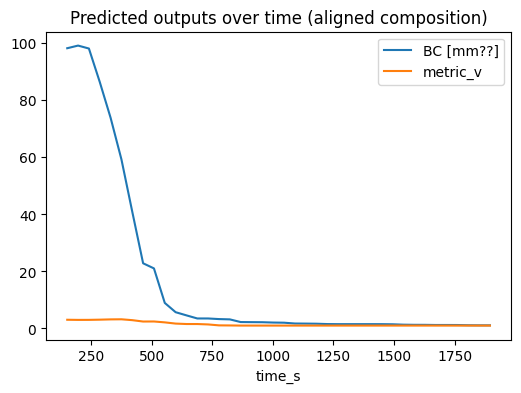

In [40]:

# Time-series sweep: predict over time for a chosen composition, map by nearest time only
import matplotlib.pyplot as plt
from matplotlib import animation
import numpy as np

N_STEPS = 40

# Pick a composition key explicitly (first non-None by default)
non_none = [ck for ck in comp_data.keys() if ck is not None]
if not non_none:
    raise RuntimeError('No composition keys available for time sweep.')
ck_time = non_none[0]  # change this to select a specific composition

# Use the comp_data for this composition
comp_times = comp_data[ck_time]['times']
comp_frames = comp_data[ck_time]['frames']
comp_y = comp_data[ck_time]['y'].to_numpy()

T_MIN, T_MAX = float(comp_times.min()), float(comp_times.max())
time_grid = np.linspace(T_MIN, T_MAX, N_STEPS)

base_inputs = {col: 0.0 for col in input_cols}
base_inputs.update({
    'surfactant_coco_b_wt_pct': float(df.get('surfactant_coco_b_wt_pct', pd.Series([0])).median()),
    'surfactant_coco_betain_wt_pct': float(df.get('surfactant_coco_betain_wt_pct', pd.Series([0])).median()),
    'surfactant_capryl_glucoside_wt_pct': float(df.get('surfactant_capryl_glucoside_wt_pct', pd.Series([0])).median()),
    'surfactant_coco_glucoside_wt_pct': float(df.get('surfactant_coco_glucoside_wt_pct', pd.Series([0])).median()),
    'nanoparticle_al2o3_wt_pct': float(df.get('nanoparticle_al2o3_wt_pct', pd.Series([0])).median()),
})
if 'temperature_c' in input_cols:
    base_inputs['temperature_c'] = float(df.get('temperature_c', pd.Series([0])).median())

rows = []
for t in time_grid:
    row = {col: base_inputs.get(col, 0.0) for col in input_cols}
    row['time_s'] = t
    rows.append(row)
X_time = pd.DataFrame(rows)

pred_time = model.predict(X_time)
# Optional smoothing to reduce frame hopping
pred_time_smooth = pd.DataFrame(pred_time, columns=target_cols).rolling(window=3, min_periods=1, center=True).mean().to_numpy()

frames_time = []
for t, pv in zip(time_grid, pred_time_smooth):
    # pick nearest time only (no output NN)
    idx = int(np.argmin(np.abs(comp_times - t)))
    frames_time.append(comp_frames[idx])

frames_time = np.stack(frames_time)

fig, ax = plt.subplots(figsize=(4, 4))
im = ax.imshow(frames_time[0], cmap='gray', animated=True)
ax.axis('off')

def init():
    im.set_data(frames_time[0])
    return (im,)

def update(i):
    im.set_data(frames_time[i])
    ax.set_title(f't = {time_grid[i]:.1f}s')
    return (im,)

anim = animation.FuncAnimation(fig, update, init_func=init, frames=len(frames_time), interval=200, blit=True)
plt.show()

pred_df = pd.DataFrame(pred_time_smooth, columns=target_cols)
plt.figure(figsize=(6,4))
for col in ['BC [mm??]', 'metric_v']:
    if col in pred_df.columns:
        plt.plot(time_grid, pred_df[col], label=col)
plt.xlabel('time_s')
plt.legend()
plt.title('Predicted outputs over time (nearest-time mapping)')
plt.show()


In [41]:

# Save the time-sweep animation to GIF
if 'anim' not in globals():
    raise RuntimeError('Run the time-sweep cell first to create `anim`.')

out_gif = Path('time_sweep.gif')
anim.save(out_gif, writer='pillow', fps=5)
print('Saved animation to', out_gif.resolve())


Saved animation to C:\Users\aisci\OneDrive\Desktop\Foam bubble data\AisciaMicroscopeHackathon\DTMicroscope\notebooks\foam\time_sweep.gif


In [21]:

# Heights over time (if height columns exist)
import matplotlib.pyplot as plt

height_cols = [c for c in df.columns if 'h' in c.lower() and 'mm' in c.lower()]
foam_col = next((c for c in height_cols if 'foam' in c.lower()), None)
liquid_col = next((c for c in height_cols if 'liquid' in c.lower()), None)

if foam_col and liquid_col:
    plt.figure(figsize=(6,4))
    plt.plot(df['time_s'], df[foam_col], label=foam_col)
    plt.plot(df['time_s'], df[liquid_col], label=liquid_col)
    plt.xlabel('time_s')
    plt.ylabel('height (mm)')
    plt.title('Heights vs time (full table)')
    plt.legend()
    plt.show()
else:
    print('Height columns not found in CSV; skipping height plot.')


Height columns not found in CSV; skipping height plot.


In [22]:

# Plot raw heights vs time directly from HD Excel (if available)
import pandas as pd
import matplotlib.pyplot as plt

for h5 in h5_files:
    with h5py.File(h5, 'r') as f:
        md = f['Measurement_000/metadata']
        hd_path = md.attrs.get('hd_file')
        if hd_path is None:
            continue
        hd_path = Path(hd_path)
        if not hd_path.exists():
            continue
        try:
            hd_df = pd.read_excel(hd_path)
        except Exception as e:
            print('Failed to read', hd_path, ':', e)
            continue
        if not {'t [s]', 'hfoam [mm]', 'hliquid [mm]'}.issubset(hd_df.columns):
            continue
        plt.figure(figsize=(6,4))
        plt.plot(hd_df['t [s]'], hd_df['hfoam [mm]'], label='hfoam [mm]')
        plt.plot(hd_df['t [s]'], hd_df['hliquid [mm]'], label='hliquid [mm]')
        plt.xlabel('time [s]')
        plt.ylabel('height [mm]')
        plt.title(f'Heights vs time: {h5.name}')
        plt.legend()
        plt.show()


In [23]:

# Plot radii vs time from BD Excel (if available)
import pandas as pd
import matplotlib.pyplot as plt
import h5py
from pathlib import Path

plotted = 0
for h5 in h5_files:
    with h5py.File(h5, 'r') as f:
        md = f['Measurement_000/metadata']
        bd_path = md.attrs.get('bd_file')
    if not bd_path:
        continue
    bd_path = Path(bd_path)
    if not bd_path.exists():
        print(f"BD missing for {h5.name}: {bd_path}")
        continue
    try:
        bd_df = pd.read_excel(bd_path)
    except Exception as e:
        print(f"Failed to read {bd_path}: {e}")
        continue
    required = {'t [s]', 'Ravg [?m]', 'Rrms [?m]', 'R21 [?m]', 'R32 [?m]'}
    if not required.issubset(bd_df.columns):
        print(f"Radius columns missing in {bd_path.name}")
        continue
    plt.figure(figsize=(7,4))
    plt.plot(bd_df['t [s]'], bd_df['Ravg [?m]'], label='Ravg [?m]')
    plt.plot(bd_df['t [s]'], bd_df['Rrms [?m]'], label='Rrms [?m]')
    plt.plot(bd_df['t [s]'], bd_df['R21 [?m]'], label='R21 [?m]')
    plt.plot(bd_df['t [s]'], bd_df['R32 [?m]'], label='R32 [?m]')
    plt.xlabel('time [s]')
    plt.ylabel('radius [?m]')
    plt.title(f'Radii vs time: {h5.name}')
    plt.legend()
    plt.show()
    plotted += 1

if plotted == 0:
    print('No BD files with radius columns found; nothing to plot.')


BD missing for 0_25_wt_coco_b_0_75wt_coco_glucoside.h5: AisciaMicroscopeHackathon\0.25 wt% coco- B & 0.75wt % coco-Glucoside\0.25 wt%   coco-betain & 0.75wt %coco- glucoside BD.xlsx
BD missing for 0_5_wt_coco_betain_0_5wt_capryl_glucoside.h5: AisciaMicroscopeHackathon\0.5 wt% coco-betain & 0.5wt % Capryl-glucoside\0.5 wt% coco-betain & 0.5wt % Capryl-glucoside BD.xlsx
BD missing for 0_5_wt_coco_betain_0_5wt_coco_glucoside.h5: AisciaMicroscopeHackathon\0.5 wt% coco-betain & 0.5wt % coco-glucoside\0.5 wt% coco-betain & 0.5wt % coco-glucoside with structure BD.xlsx
BD missing for 1_wt_capryl_glucoside.h5: AisciaMicroscopeHackathon\1 wt% Capryl-Glucoside\1 wt% Capryl-Glucoside with structures BD.xlsx
BD missing for 1wt_coco_glucoside.h5: AisciaMicroscopeHackathon\1wt% Coco Glucoside\1wt% Coco Glucoside with Structure BD.xlsx
BD missing for nanoparticle_0_00625_wt.h5: AisciaMicroscopeHackathon\COCO betaine 1 wt.% with nanoparticles\Al2O3\0.00625 wt.%\BD 1 wt % New CoCO-Betaine 0.00625 Al2O3

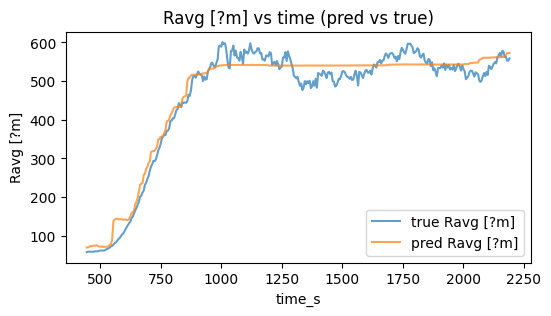

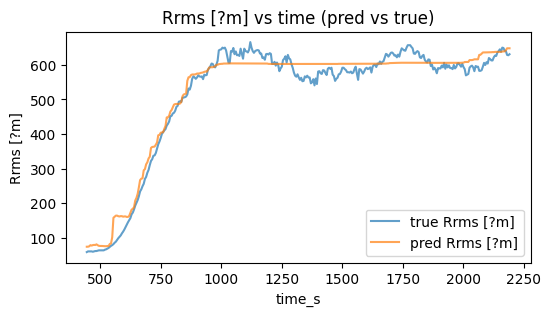

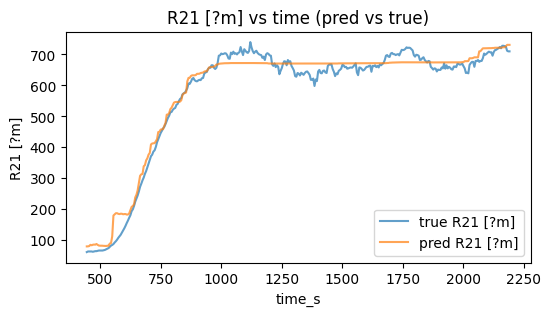

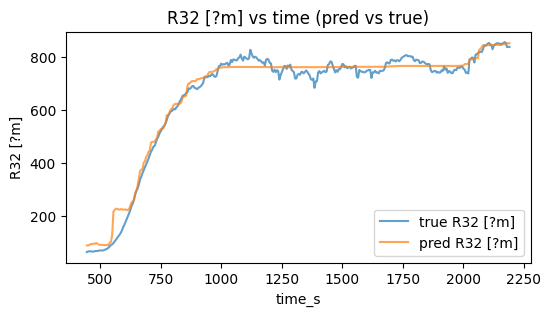

In [24]:

# Predicted vs true radii over time (model outputs)
import matplotlib.pyplot as plt

# Choose one composition (first non-None) for clarity; otherwise use all
unique_comps = [ck for ck in set(comp_keys_aligned) if ck is not None]
if unique_comps:
    sel_idxs = [i for i,k in enumerate(comp_keys_aligned) if k == unique_comps[0]]
else:
    sel_idxs = list(range(len(preds)))

pred_df = pd.DataFrame(preds[sel_idxs], columns=target_cols)
true_df = y.iloc[sel_idxs].reset_index(drop=True)
t_vals = X.iloc[sel_idxs]['time_s'].to_numpy()

for col in ['Ravg [?m]', 'Rrms [?m]', 'R21 [?m]', 'R32 [?m]']:
    if col not in pred_df.columns:
        continue
    plt.figure(figsize=(6,3))
    plt.plot(t_vals, true_df[col], label=f'true {col}', alpha=0.7)
    plt.plot(t_vals, pred_df[col], label=f'pred {col}', alpha=0.7)
    plt.xlabel('time_s')
    plt.ylabel(col)
    plt.title(f'{col} vs time (pred vs true)')
    plt.legend()
    plt.show()


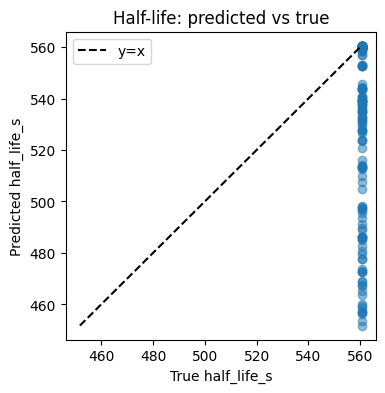

In [25]:

# Predicted vs true half-life (per composition if available)
import matplotlib.pyplot as plt

unique_comps = [ck for ck in set(comp_keys_aligned) if ck is not None]
if unique_comps:
    sel_idxs = [i for i,k in enumerate(comp_keys_aligned) if k == unique_comps[0]]
else:
    sel_idxs = list(range(len(preds)))

pred_series = pd.Series(preds[sel_idxs, target_cols.index('half_life_s')])
true_series = y.iloc[sel_idxs]['half_life_s'].reset_index(drop=True)

plt.figure(figsize=(4,4))
plt.scatter(true_series, pred_series, alpha=0.5)
lims = [min(true_series.min(), pred_series.min()), max(true_series.max(), pred_series.max())]
plt.plot(lims, lims, 'k--', label='y=x')
plt.xlabel('True half_life_s')
plt.ylabel('Predicted half_life_s')
plt.title('Half-life: predicted vs true')
plt.legend()
plt.show()


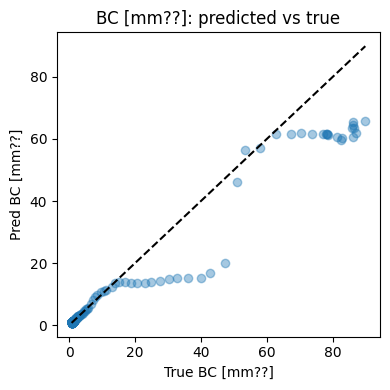

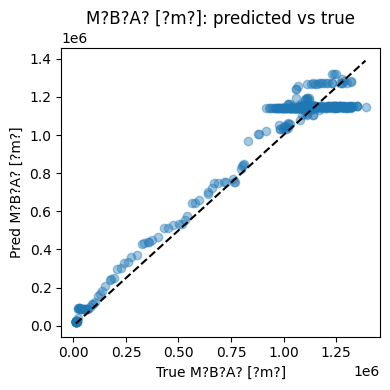

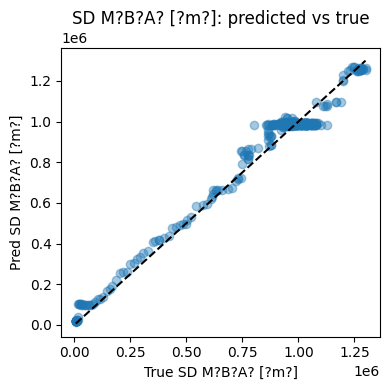

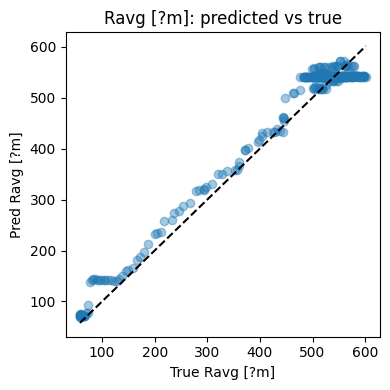

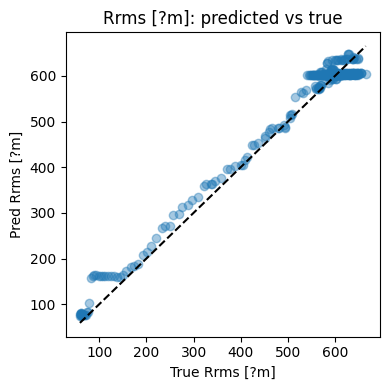

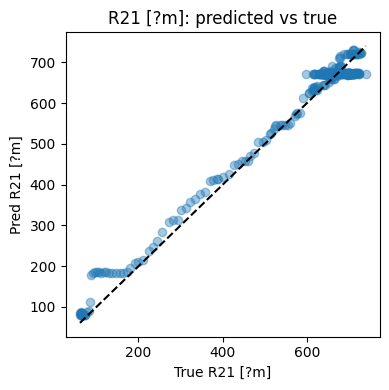

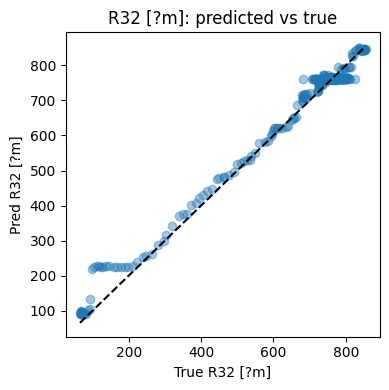

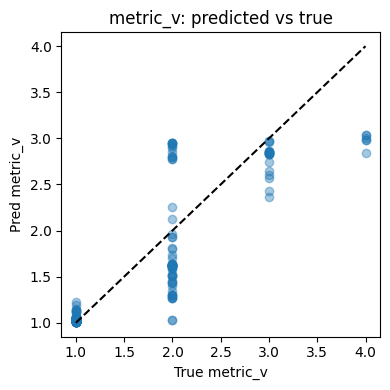

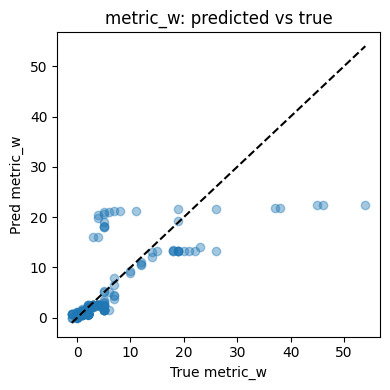

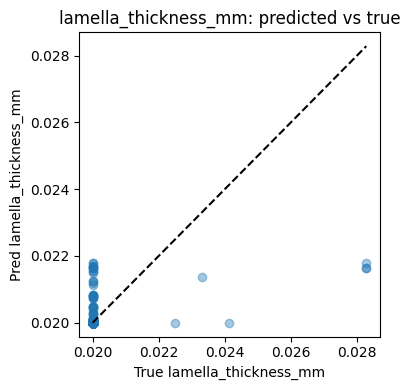

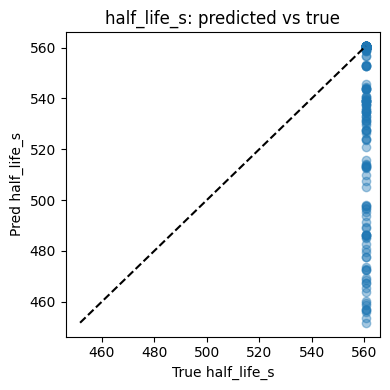

In [26]:

# Scatter plots: predicted vs true for each target
import matplotlib.pyplot as plt
pred_df = pd.DataFrame(preds, columns=target_cols)
true_df = y.reset_index(drop=True)

for col in target_cols:
    plt.figure(figsize=(4, 4))
    plt.scatter(true_df[col], pred_df[col], alpha=0.4)
    lims = [min(true_df[col].min(), pred_df[col].min()), max(true_df[col].max(), pred_df[col].max())]
    plt.plot(lims, lims, 'k--')
    plt.xlabel(f'True {col}')
    plt.ylabel(f'Pred {col}')
    plt.title(f'{col}: predicted vs true')
    plt.tight_layout()
    plt.show()


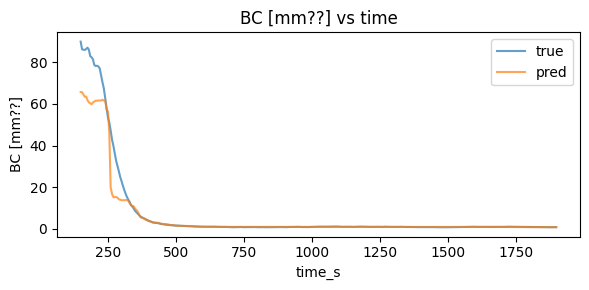

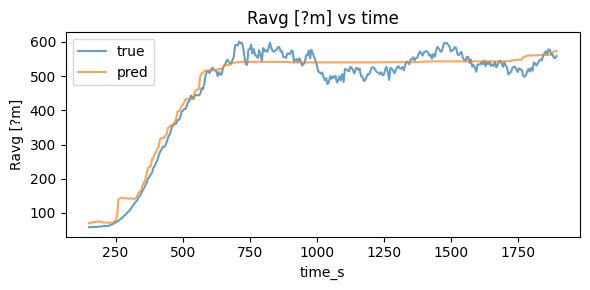

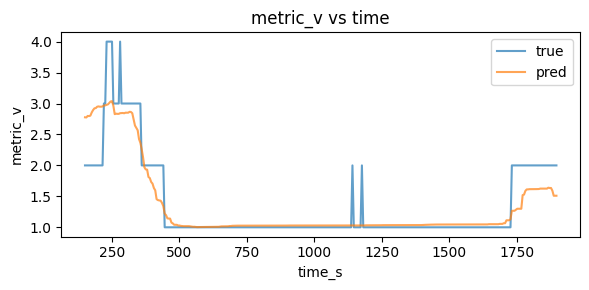

In [27]:

# Time traces (true vs predicted) for one composition or all data
import numpy as np
import matplotlib.pyplot as plt

unique_comps = [ck for ck in set(comp_keys_aligned) if ck is not None]
if unique_comps:
    comp = unique_comps[0]
    idxs = [i for i, k in enumerate(comp_keys_aligned) if k == comp]
else:
    idxs = list(range(len(preds)))

t_vals = times_arr[idxs]
order = np.argsort(t_vals)
t_vals = t_vals[order]
pred_sel = preds[idxs][order]
true_sel = y.iloc[idxs].reset_index(drop=True).iloc[order]

for col in ['BC [mm??]', 'Ravg [?m]', 'metric_v']:
    if col not in target_cols:
        continue
    plt.figure(figsize=(6, 3))
    plt.plot(t_vals, true_sel[col], label='true', alpha=0.7)
    col_idx = target_cols.index(col)
    plt.plot(t_vals, pred_sel[:, col_idx], label='pred', alpha=0.7)
    plt.xlabel('time_s')
    plt.ylabel(col)
    plt.title(f'{col} vs time')
    plt.legend()
    plt.tight_layout()
    plt.show()


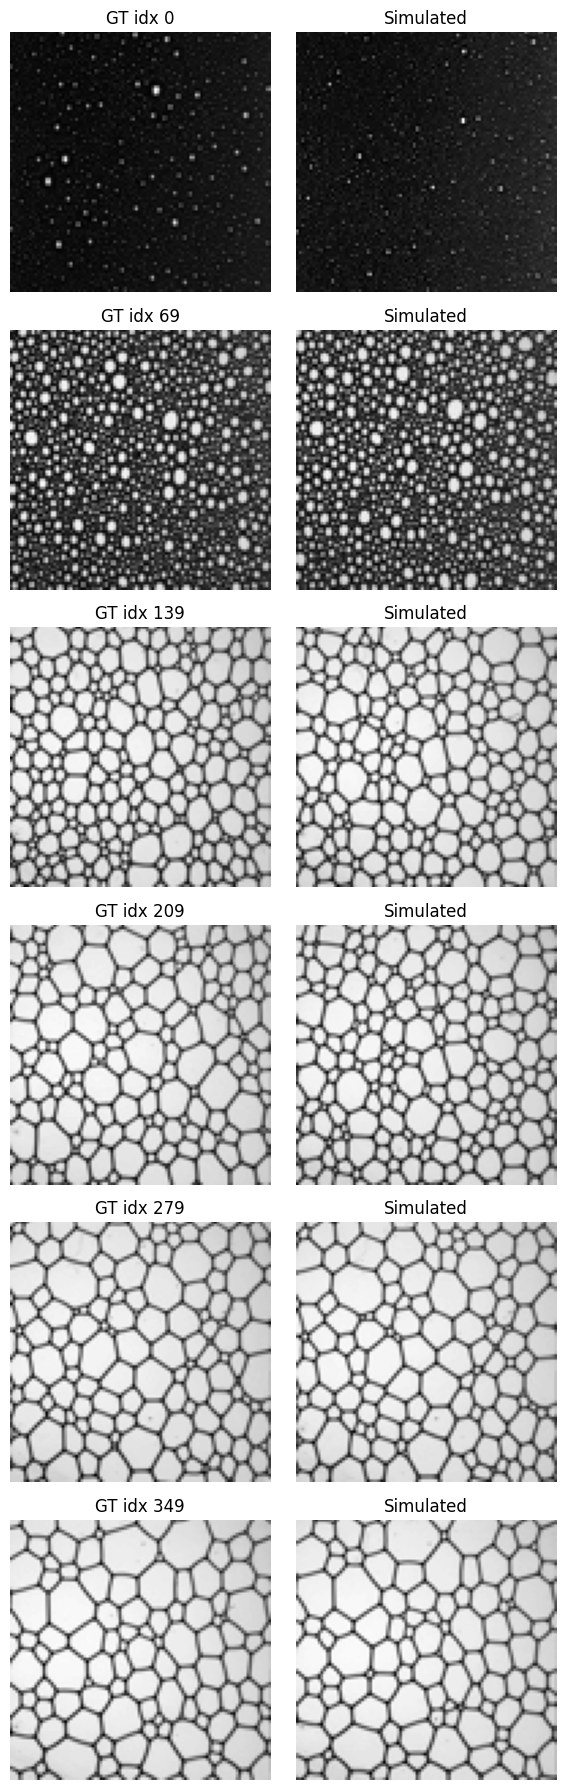

In [28]:

# Quick gallery of ground-truth vs simulated frames
import numpy as np
import matplotlib.pyplot as plt

if len(all_frames) > 0:
    sel_idxs = np.linspace(0, len(all_frames) - 1, min(6, len(all_frames)), dtype=int)
    n = len(sel_idxs)
    fig, axes = plt.subplots(n, 2, figsize=(6, 3*n))
    for r, idx in enumerate(sel_idxs):
        axes[r, 0].imshow(all_frames[idx], cmap='gray')
        axes[r, 0].set_title(f'GT idx {idx}')
        axes[r, 0].axis('off')
        axes[r, 1].imshow(sim_frames[idx], cmap='gray')
        axes[r, 1].set_title('Simulated')
        axes[r, 1].axis('off')
    plt.tight_layout()
    plt.show()
else:
    print('No frames available to plot grid.')


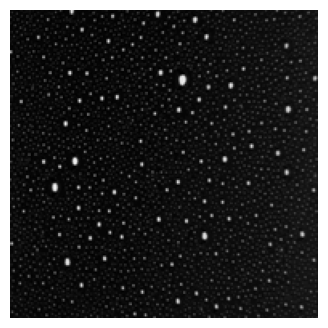

In [46]:

# Alternative animation: keep all rows, fallback to global frames if composition missing
import matplotlib.pyplot as plt
from matplotlib import animation
import numpy as np
from sklearn.preprocessing import StandardScaler

N_STEPS = 40
TIME_WEIGHT = 0.2

# Build a global frame pool with times (aligned with all_rows)
all_rows = df.copy().reset_index(drop=True)
all_times = all_rows['time_s'].to_numpy()
all_preds = model.predict(all_rows[input_cols].fillna(all_rows[input_cols].median(numeric_only=True)))

# Composition-aware grouping for those with matches
comp_to_idxs = {}
for i, row in all_rows.iterrows():
    ck = comp_key_from_row(row)
    comp_to_idxs.setdefault(ck, []).append(i)

# Choose best composition if available; else use global
surf_cols = [c for c in input_cols if c.startswith('surfactant_')]
base_inputs = {col: 0.0 for col in input_cols}
base_inputs.update({
    'surfactant_coco_b_wt_pct': float(df.get('surfactant_coco_b_wt_pct', pd.Series([0])).median()),
    'surfactant_coco_betain_wt_pct': float(df.get('surfactant_coco_betain_wt_pct', pd.Series([0])).median()),
    'surfactant_capryl_glucoside_wt_pct': float(df.get('surfactant_capryl_glucoside_wt_pct', pd.Series([0])).median()),
    'surfactant_coco_glucoside_wt_pct': float(df.get('surfactant_coco_glucoside_wt_pct', pd.Series([0])).median()),
    'nanoparticle_al2o3_wt_pct': float(df.get('nanoparticle_al2o3_wt_pct', pd.Series([0])).median()),
})
if 'temperature_c' in input_cols:
    base_inputs['temperature_c'] = float(df.get('temperature_c', pd.Series([0])).median())

def best_ck():
    def comp_vec(ck):
        vec = []
        ck_dict = {s: w for s, w in ck} if ck else {}
        for col in surf_cols:
            norm = normalize_surf(col.replace('surfactant_', '').replace('_wt_pct', ''))
            vec.append(base_inputs.get(col, 0.0) - ck_dict.get(norm, 0.0))
        return np.linalg.norm(vec)
    best, dist = None, None
    for ck in comp_to_frames.keys():
        d = comp_vec(ck)
        if dist is None or d < dist:
            dist = d; best = ck
    return best

ck_choice = best_ck()

if ck_choice in comp_data:
    times_src = comp_data[ck_choice]['times']
    frames_src = comp_data[ck_choice]['frames']
    y_src = comp_data[ck_choice]['y'].to_numpy()
else:
    # use global alignment (all frames already stacked to matching rows)
    times_src = times_arr if 'times_arr' in globals() else all_times
    frames_src = all_frames if 'all_frames' in globals() else np.empty((0,))
    y_src = y.to_numpy() if 'y' in globals() else all_preds

T_MIN, T_MAX = float(np.min(times_src)), float(np.max(times_src))
time_grid = np.linspace(T_MIN, T_MAX, N_STEPS)

frames_time_alt = []
scaler_t = StandardScaler().fit(y_src)
y_scaled = scaler_t.transform(y_src)

for t in time_grid:
    # nearest few times
    time_dist = np.abs(times_src - t)
    nearest_idx = np.argsort(time_dist)[:5]
    pv = model.predict(pd.DataFrame([{**base_inputs, 'time_s': t} for _ in range(1)]))[0]
    pv_scaled = scaler_t.transform([pv])[0]
    dists = TIME_WEIGHT * time_dist[nearest_idx]**2 + np.sum((y_scaled[nearest_idx] - pv_scaled)**2, axis=1)
    pick = nearest_idx[np.argmin(dists)]
    frames_time_alt.append(frames_src[pick])

frames_time_alt = np.stack(frames_time_alt)

fig, ax = plt.subplots(figsize=(4, 4))
im = ax.imshow(frames_time_alt[0], cmap='gray', animated=True)
ax.axis('off')

def init():
    im.set_data(frames_time_alt[0])
    return (im,)

def update(i):
    im.set_data(frames_time_alt[i])
    ax.set_title(f't = {time_grid[i]:.1f}s')
    return (im,)

anim_alt = animation.FuncAnimation(fig, update, init_func=init, frames=len(frames_time_alt), interval=200, blit=True)
plt.show()


In [47]:

# Save the alternative animation if it exists
if 'anim_alt' not in globals():
    raise RuntimeError('Run the alternative animation cell first to create nim_alt.')

out_gif_alt = Path('time_sweep_alt.gif')
anim_alt.save(out_gif_alt, writer='pillow', fps=5)
print('Saved alternative animation to', out_gif_alt.resolve())


Saved alternative animation to C:\Users\aisci\OneDrive\Desktop\Foam bubble data\AisciaMicroscopeHackathon\DTMicroscope\notebooks\foam\time_sweep_alt.gif


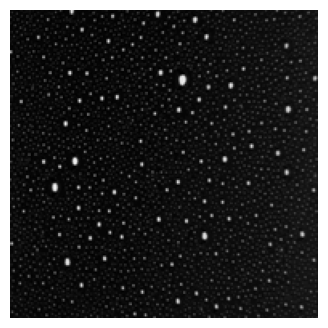

Saved alternative animation to C:\Users\aisci\OneDrive\Desktop\Foam bubble data\AisciaMicroscopeHackathon\DTMicroscope\notebooks\foam\time_sweep_altt.gif


In [45]:
# Animate actual frames for a chosen composition (time-ordered, no NN)
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation

# pick a composition you want; here the first available non-None
non_none = [ck for ck in comp_data.keys() if ck is not None]
if not non_none:
    raise RuntimeError("No composition keys available.")
ck_use = non_none[0]  # replace with the one you need

times_arr = comp_data[ck_use]['times']
frames_arr = comp_data[ck_use]['frames']
order = np.argsort(times_arr)
times_sorted = times_arr[order]
frames_sorted = frames_arr[order]

fig, ax = plt.subplots(figsize=(4, 4))
im = ax.imshow(frames_sorted[0], cmap='gray', animated=True)
ax.axis('off')

def init():
    im.set_data(frames_sorted[0]); return (im,)
def update(i):
    im.set_data(frames_sorted[i])
    ax.set_title(f"t = {times_sorted[i]:.1f}s")
    return (im,)

anim_actual = animation.FuncAnimation(
    fig, update, init_func=init,
    frames=len(frames_sorted), interval=150, blit=True
)
plt.show()





out_gif_alt = Path('time_sweep_altt.gif')
anim_alt.save(out_gif_alt, writer='pillow', fps=5)
print('Saved alternative animation to', out_gif_alt.resolve())



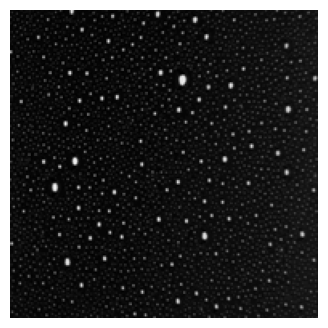

In [48]:

# Animate actual frames for a chosen real composition (time-ordered, no NN)
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation

# Pick a real composition key (first non-None, or adjust as needed)
non_none = [ck for ck in comp_data.keys() if ck is not None]
if not non_none:
    raise RuntimeError('No composition keys available for real-frame animation.')
ck_use = non_none[0]  # replace with a specific key if desired

# Ensure we have data for it
if ck_use not in comp_data:
    raise RuntimeError(f'Composition {ck_use} not found in comp_data.')

# Sort by time
_times = comp_data[ck_use]['times']
_frames = comp_data[ck_use]['frames']
order = np.argsort(_times)
times_sorted = _times[order]
frames_sorted = _frames[order]

fig, ax = plt.subplots(figsize=(4, 4))
im = ax.imshow(frames_sorted[0], cmap='gray', animated=True)
ax.axis('off')

def init():
    im.set_data(frames_sorted[0]); return (im,)

def update(i):
    im.set_data(frames_sorted[i])
    ax.set_title(f't = {times_sorted[i]:.1f}s')
    return (im,)

anim_real = animation.FuncAnimation(
    fig, update, init_func=init,
    frames=len(frames_sorted), interval=150, blit=True
)
plt.show()


In [50]:

# Save the real-composition animation (run the anim_real cell first)
if 'anim_real' not in globals():
    raise RuntimeError('Run the real-composition animation cell first to create anim_real.')

out_gif_real = Path('time_sweep_real.gif')
anim_real.save(out_gif_real, writer='pillow', fps=6)
print('Saved real composition animation to', out_gif_real.resolve())


Saved real composition animation to C:\Users\aisci\OneDrive\Desktop\Foam bubble data\AisciaMicroscopeHackathon\DTMicroscope\notebooks\foam\time_sweep_real.gif


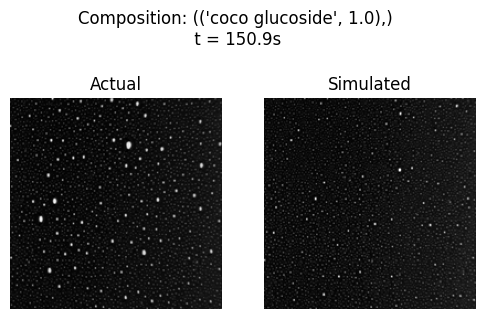

In [59]:

# Simulated vs actual animation for one real composition (side-by-side, nearest-time mapping)
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation

non_none = [ck for ck in set(comp_keys_aligned) if ck is not None]
if not non_none:
    raise RuntimeError('No composition keys available for comparison animation.')
ck_use = non_none[0]  # replace with a specific key if desired

idxs = [i for i, k in enumerate(comp_keys_aligned) if k == ck_use]
if not idxs:
    raise RuntimeError(f'No rows found for composition {ck_use}.')

sel_times = np.array(times_arr)[idxs]
order = np.argsort(sel_times)
sel_times = sel_times[order]
actual_frames = all_frames[idxs][order]
sim_frames_sel = sim_frames[idxs][order]

fig, axes = plt.subplots(1, 2, figsize=(6, 4))
ims = [axes[0].imshow(actual_frames[0], cmap='gray', animated=True),
       axes[1].imshow(sim_frames_sel[0], cmap='gray', animated=True)]
axes[0].set_title('Actual'); axes[0].axis('off')
axes[1].set_title('Simulated'); axes[1].axis('off')
fig.suptitle(f"Composition: {ck_use}\n t = {sel_times[0]:.1f}s")

def init():
    ims[0].set_data(actual_frames[0])
    ims[1].set_data(sim_frames_sel[0])
    return ims

def update(i):
    ims[0].set_data(actual_frames[i])
    ims[1].set_data(sim_frames_sel[i])
    fig.suptitle(f"Composition: {ck_use}\n t = {sel_times[i]:.1f}s")
    return ims

anim_compare = animation.FuncAnimation(
    fig, update, init_func=init,
    frames=len(actual_frames), interval=150, blit=True
)
plt.show()


In [60]:

# Save the simulated vs actual comparison animation
if 'anim_compare' not in globals():
    raise RuntimeError('Run the comparison animation cell first to create anim_compare.')

out_gif_cmp = Path('time_sweep_compare.gif')
anim_compare.save(out_gif_cmp, writer='pillow', fps=6)
print('Saved comparison animation to', out_gif_cmp.resolve())


Saved comparison animation to C:\Users\aisci\OneDrive\Desktop\Foam bubble data\AisciaMicroscopeHackathon\DTMicroscope\notebooks\foam\time_sweep_compare.gif


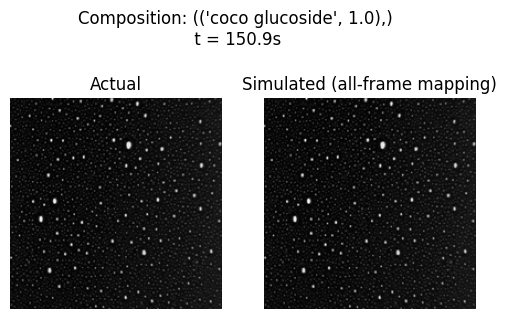

In [61]:

# Comparison using simulated frames mapped over all data (fallback-aware), aligned to actual
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation

# Choose composition for the actual side
non_none = [ck for ck in set(comp_keys_aligned) if ck is not None]
if not non_none:
    raise RuntimeError('No composition keys available for comparison animation.')
ck_use = non_none[0]  # change if you want a specific composition

idxs = [i for i, k in enumerate(comp_keys_aligned) if k == ck_use]
if not idxs:
    raise RuntimeError(f'No rows found for composition {ck_use}.')

sel_times = np.array(times_arr)[idxs]
order = np.argsort(sel_times)
sel_times = sel_times[order]
actual_frames = all_frames[idxs][order]

# Simulated side: use frames_time_alt if available (built from all rows); otherwise use sim_frames
if 'frames_time_alt' in globals():
    sim_source = frames_time_alt
else:
    sim_source = sim_frames

# Align lengths
n = min(len(actual_frames), len(sim_source))
actual_frames = actual_frames[:n]
sim_frames_aligned = sim_source[:n]
sel_times = sel_times[:n]

fig, axes = plt.subplots(1, 2, figsize=(6, 4))
ims = [axes[0].imshow(actual_frames[0], cmap='gray', animated=True),
       axes[1].imshow(sim_frames_aligned[0], cmap='gray', animated=True)]
axes[0].set_title('Actual'); axes[0].axis('off')
axes[1].set_title('Simulated (all-frame mapping)'); axes[1].axis('off')
fig.suptitle(f"Composition: {ck_use}\n t = {sel_times[0]:.1f}s")

def init():
    ims[0].set_data(actual_frames[0])
    ims[1].set_data(sim_frames_aligned[0])
    return ims

def update(i):
    ims[0].set_data(actual_frames[i])
    ims[1].set_data(sim_frames_aligned[i])
    fig.suptitle(f"Composition: {ck_use}\n t = {sel_times[i]:.1f}s")
    return ims

anim_compare_all = animation.FuncAnimation(
    fig, update, init_func=init,
    frames=len(actual_frames), interval=150, blit=True
)
plt.show()


In [62]:

# Save the all-frame comparison animation
if 'anim_compare_all' not in globals():
    raise RuntimeError('Run the all-frame comparison animation cell first.')

out_gif_cmp_all = Path('time_sweep_compare_all.gif')
anim_compare_all.save(out_gif_cmp_all, writer='pillow', fps=6)
print('Saved all-frame comparison animation to', out_gif_cmp_all.resolve())


Saved all-frame comparison animation to C:\Users\aisci\OneDrive\Desktop\Foam bubble data\AisciaMicroscopeHackathon\DTMicroscope\notebooks\foam\time_sweep_compare_all.gif
